# Classification : Bayésien naïf, LDA, QDA, et $k$-Plus Proches Voisins

L'objectif de cette séance de TD/TP est
1. d'implémenter les différents algorithmes de classificaion vus en cours 
 * bayésien naïf
 * LDA et QDA 
 * $k$-PPV
2. d'évaluer les performances de classification sur *les échantillons d'apprentissage*
 * calcul d'une matrice de confusion
 * calcul de l'Overall Accuracy et du coefficient Kappa
3. de visualiser les frontières de décision obtenues par les algorithmes de classification

L'ensemble des algorithmes à implémenter sont déterministiques (c'est-à-dire qu'ils ne dépendent pas d'un caractère aléatoire). Vos implémentations devraient donc théoriquement vous donner des résultats strictement identiques à ceux de Scikit-Learn. Cependant, la résolution de LDA par Scikit-Learn n'est pas exacte et l'algorithme des k-PPV peut utiliser de l'aléatoire pour départager les cas d'égalité lors de l'affectation de la classe majoritaire (diapo 32 du cours).

**Indication** : le découpage en fonction (avec les résultats attendus) est là pour vous aider à modulariser votre code. Cependant, vous pouvez partir sur un tout autre choix d'implémentation (notamment d'autres paradigmes de programmation comme l'orienté objet ou le fonctionnel).


## Jeu de données

In [1]:
#-- import
from sklearn import datasets
import math
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics.pairwise import euclidean_distances #to compute pairwise distances
from numpy.linalg import inv #to compute X^-1

In [2]:
#-- Charger le jeu de données iris
iris = datasets.load_iris()
X = iris.data[:,0:2] # on garde uniquement deux variables explicatives
X = (X-X.mean(axis=0))/X.std(axis=0,ddof=0)
y = iris.target

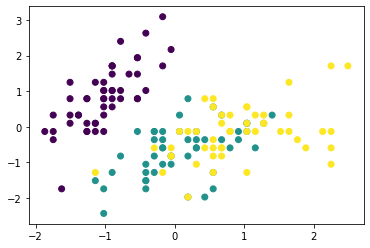

In [3]:
#-- Scatterplot
plt.figure()
plt.scatter(X[:,0],X[:,1], c=y) #plot the points with their label
plt.show()

## Classifieur bayésien naïf

### 1.  Algotihme de Scikit-learn


In [4]:
#-- Trouver le nombre de classes
C = len(np.unique(y))
print("C =", C)

C = 3


In [5]:
#-- Bayésien naif gaussien
gnb = GaussianNB()
y_pred = gnb.fit(X, y).predict(X)
print ("Taux d'erreur du classifieur bayésien naïf", np.mean(y_pred != y))

Taux d'erreur du classifieur bayésien naïf 0.22


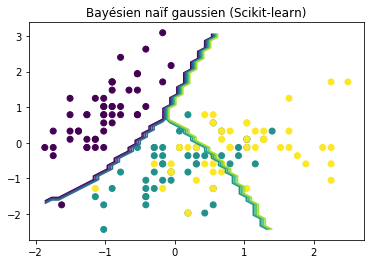

In [6]:
#-- Figure (frontières de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = gnb.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Bayésien naïf gaussien (Scikit-learn)")
plt.show()

### 2. Votre version de l'algorithme Bayésien naif

Astuces : 
* `np.bincount(y)` permet de compter le nombre d'occurences dans une classe
* `np.mean` et `np.var` permettent de calculer la moyenne et la variance pour une variable explicative
* loi normale pour $z$ la variable aléatoire : $p(z) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{1}{2\sigma^2}(z-\mu)^2}$
* `grid = np.c_[xx.ravel(),yy.ravel()]` défini une matrice avec toutes les positions sur une grille (cf. le code de la Figure ci-dessus)

In [7]:
#-- probabilité a priori (Pr(Y=y))
def proba_classe(Y):
    return np.bincount(Y)/Y.shape[0]


In [8]:
print(proba_classe(y)) #- fréquence d'apparition de chacune des classes dans les données d'apprentissage

[0.33333333 0.33333333 0.33333333]


## Résultat attendu
\[0.33333333 0.33333333 0.33333333\]

In [9]:
def estimation_param_nb(X,Y):
    m, d = X.shape
    sigma = []
    mu = []
    for i in np.unique(Y): # 3
        tab = []
        tab2 = []
        for k in range(d): #2
            cell = []
            for j in range(m):
                if(i == Y[j]):
                    cell.append(X[j,k])
            tab.append(np.mean(cell))
            tab2.append(np.var(cell))
        mu.append(tab)
        sigma.append(tab2)
    return np.asarray(mu), np.asarray(sigma)

In [10]:
print(estimation_param_nb(X,y))

(array([[-1.01457897,  0.85326268],
       [ 0.11228223, -0.66143204],
       [ 0.90229674, -0.19183064]]), array([[0.17876968, 0.74619175],
       [0.38334383, 0.51135882],
       [0.5817693 , 0.54010089]]))


## Résultat attendu
(array(\[\[-1.01457897,  0.85326268\],
       \[ 0.11228223, -0.66143204\],
       \[ 0.90229674, -0.19183064\]\]), 
array(\[\[0.17876968, 0.74619175\],
       \[0.38334383, 0.51135882\],
       \[0.5817693 , 0.54010089\]\]))

In [11]:
#-- loi normale (1D)
def loi_normale(X, mu=0, sigma2=1):
    return np.exp(-(X - mu)**2 / (2*sigma2)) / (2 * np.pi * sigma2)**(0.5)

In [12]:
loi_normale(X[:,0], mu=0, sigma2=1)[:10]

array([0.26592211, 0.20759165, 0.15281312, 0.12825426, 0.23668473,
       0.34534257, 0.12825426, 0.23668473, 0.08645012, 0.20759165])

## Résultat attendu
array(\[0.26592211, 0.20759165, 0.15281312, 0.12825426, 0.23668473,
       0.34534257, 0.12825426, 0.23668473, 0.08645012, 0.20759165\])

In [13]:
#-- vraisemblance (Pr(X=x|Y=y)) en fonction des paramètres mu et sigma
def vraisemblance_nb(X, mu, sigma): 
    m, d = X.shape
    c = mu.shape[0]
    res = np.zeros((m,c))
    
    for i in range(c):
        res[:,i] = np.prod([loi_normale(X[:,k], mu[i][k], sigma[i][k]) for k in range(d)], axis=0)
    return  res

In [14]:
mu, sigma2 = estimation_param_nb(X,y)
print(vraisemblance_nb(X, mu, sigma2)[:10,:])

[[4.12568710e-01 5.96043661e-03 4.47104459e-03]
 [2.17134544e-01 3.49960316e-02 7.76844498e-03]
 [2.46660743e-01 7.39752504e-03 2.46053810e-03]
 [1.51142680e-01 6.70198548e-03 1.79316099e-03]
 [3.92250378e-01 1.89179325e-03 1.72350876e-03]
 [1.04438709e-01 2.77596442e-04 7.12783062e-04]
 [2.20840906e-01 1.50708277e-03 7.95813815e-04]
 [4.34485017e-01 8.58896773e-03 4.83801148e-03]
 [3.58456742e-02 3.59355840e-03 6.57792476e-04]
 [2.83993851e-01 2.61821854e-02 7.21025739e-03]]


## Résultat attendu
\[\[4.12568710e-01 5.96043661e-03 4.47104459e-03\]
 \[2.17134544e-01 3.49960316e-02 7.76844498e-03\]
 \[2.46660743e-01 7.39752504e-03 2.46053810e-03\]
 \[1.51142680e-01 6.70198548e-03 1.79316099e-03\]
 \[3.92250378e-01 1.89179325e-03 1.72350876e-03\]
 \[1.04438709e-01 2.77596442e-04 7.12783062e-04\]
 \[2.20840906e-01 1.50708277e-03 7.95813815e-04\]
 \[4.34485017e-01 8.58896773e-03 4.83801148e-03\]
 \[3.58456742e-02 3.59355840e-03 6.57792476e-04\]
 \[2.83993851e-01 2.61821854e-02 7.21025739e-03\]\]

In [15]:
#-- classifieur bayésien naif (NB : Naif Bayesian classifier)
def predict_nb(X,Xtrain,ytrain):
    """
        Prédiction des étiquettes pour les échantillons X lorsque le modèle est appris sur les données (Xtrain,ytrain)
        IN:
            - X (N,d) : observations pour laquelle on souhaite prédire la classe yhat
            - Xtrain (m,d) : données d'apprentissage
            - ytrain (m,): étiqueetes associées aux données d'apprentissage
        OUT:
            - yhat (N,) : classes prédites pour les observations X 
    """
    mu, sigma2 = estimation_param_nb(Xtrain,ytrain)
    yhat = np.argmax(proba_classe(ytrain) * vraisemblance_nb(X, mu, sigma2), axis=1)
    return yhat

In [16]:
print(predict_nb(X,X,y)) # prédictions sur les données d'apprentissage (donc X=Xtrain dans ce TP)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1 2 2 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 1 2 2 2 1 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


## RESULTAT ATTENDU
\[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1 2 2 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 1 2 2 2 1 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1\]

### 3. Evaluation des performances

In [17]:
#-- Calcul de la matrice de confusion
def getConfusionMatrix(Y, yhat):
    d = len(np.unique(Y))
    result = np.zeros((d, d))
    for i in range(len(Y)):
        result[Y[i]][yhat[i]] += 1
    return result

In [18]:
#-- Calcul du taux de bonne classification (OA)
def getOA(Y, yhat):
    return np.sum(np.diagonal(getConfusionMatrix(Y, yhat))) / Y.shape[0]

In [19]:
#-- Calcul du coefficient Kappa
def getKappa(Y, yhat):
    confuse = getConfusionMatrix(Y, yhat)
    col = np.sum(confuse, axis=0)
    raw = np.sum(confuse, axis=1)
    p = np.ones((raw.shape[0]))
    for i in range(raw.shape[0]):
        p[i] = (col[i]/np.sum(raw)) * (raw[i]/np.sum(raw))
    return (getOA(Y, yhat) - np.sum(p)) / (1 - np.sum(p))
    
    

In [20]:
#-- test
yhat = predict_nb(X,X,y)
print ("Taux d'erreur du classifieur bayésien naïf", 1-getOA(y,yhat))
print ("\tet coefficient Kappa", getKappa(y,yhat))

Taux d'erreur du classifieur bayésien naïf 0.21999999999999997
	et coefficient Kappa 0.67


In [21]:
print ("Taux d'erreur du classifieur bayésien naïf (Scikit-learn)", 1-accuracy_score(y,yhat))
print ("\tet coefficient Kappa (Scikit-learn)", cohen_kappa_score(y,yhat))

Taux d'erreur du classifieur bayésien naïf (Scikit-learn) 0.21999999999999997
	et coefficient Kappa (Scikit-learn) 0.6699999999999999


## Résultat attendu
Taux d'erreur du classifieur bayésien naïf 0.21999999999999997
    et coefficient Kappa 0.67

Taux d'erreur du classifieur bayésien naïf (Scikit-learn) 0.21999999999999997
    et coefficient Kappa (Scikit-learn) 0.6699999999999999

### 4. Visualisation des frontières de décision

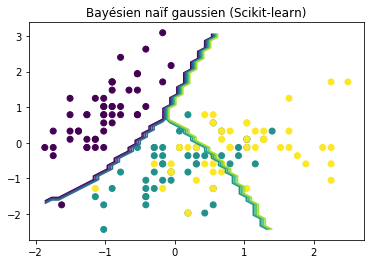

In [22]:
#-- Figure (frontières de décision) 
## A COMPARER AVEC LE PLOT INITIAL
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = predict_nb(np.c_[xx.ravel(), yy.ravel()],X,y)
Z = Z.reshape(xx.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Bayésien naïf gaussien (Scikit-learn)")
plt.show()

## LDA et QDA

### 1. Scikit-learn

In [23]:
#-- LDA 
lda = LinearDiscriminantAnalysis()
lda.fit(X, y) 
y_pred = lda.predict(X)
print ("Taux d'erreur LDA", np.mean(y_pred != y))

Taux d'erreur LDA 0.2


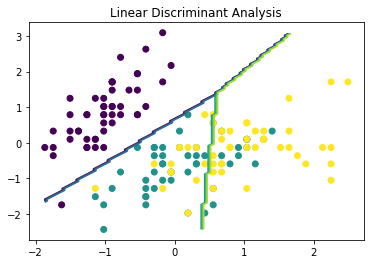

In [24]:
# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),np.arange(y_min, y_max, 0.05))
Z = lda.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Linear Discriminant Analysis")
plt.show()

In [25]:
#-- QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y) 
y_pred = qda.predict(X)
print ("Taux d'erreur QDA", np.mean(y_pred != y))

Taux d'erreur QDA 0.2


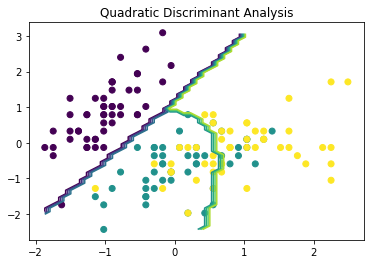

In [26]:
# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = qda.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Quadratic Discriminant Analysis")
plt.show()

### 2. Votre version des algorithmes LDA et QDA

Astuce :
* ``np.cov`` calcul de covariance d'une numpy array (`bias=True`pour obtenir des résultats identiques à l'algorithme QDA de Scikit-Learn)
* loi normale multivariée : $p(z) = \frac{1}{(2\pi)^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}(z-\mu)^T \Sigma^{-1}(z-\mu)}$
* ``np.linalg.det`` et ``np.linalg.inv`` calcul de déterminant et de l'inverse d'une numpy array
* ``np.einsum`` (non obligatoire)


In [61]:
def covariance(X, bias=False):
    return np.cov(X, rowvar=False, bias=bias)
    
    #u = X / X.shape[0]
    #up = np.sum(X) / X.shape[0]
    #T = X - up
    #return np.transpose(T).dot(T) / X.shape[0]

In [63]:
#-- Test
cov = covariance(X)
print(cov)
print(cov.shape)

[[ 1.00671141 -0.11835884]
 [-0.11835884  1.00671141]]
(2, 2)


## Résultat attendu
\[\[ 1.00671141 -0.11010327\]
 \[-0.11010327  1.00671141\]\]
(2, 2)

In [59]:
#-- loi normale multivariée
def loi_normale_multivarie(X,mu,Sigma):
    m = X.shape[0]
    ret = np.zeros(m)
    for i in range(m):
        sub = X[i] - mu
        f = np.dot(np.dot(sub,np.linalg.inv(Sigma)),np.transpose(sub))
        ret[i] = np.exp(-f/2) / (np.sqrt((2*np.pi)**X.shape[1]*np.linalg.det(Sigma))) 
    return ret


In [60]:
print(loi_normale_multivarie(X,[0, 0],[[1, 0], [0,1]])[:10])

[0.06312267 0.08209894 0.05776305 0.05091985 0.04327343 0.02099329
 0.037486   0.06917792 0.03229923 0.08241859]


## Résultat attendu
\[0.06312267 0.08209894 0.05776305 0.05091985 0.04327343 0.02099329
 0.037486   0.06917792 0.03229923 0.08241859\]

#### LDA

In [70]:
def estimation_param_lda(Xtrain, ytrain):
    nbClasses = proba_classe(ytrain).shape[0]
    mu = []
    for i in range(nbClasses):
        classe =[]
        for j in range(ytrain.shape[0]):
            if ytrain[j] == i:
                classe.append(Xtrain[j])
        mu.append(np.mean(classe,axis=0))
    return (np.asarray(mu),covariance(Xtrain,bias=True))

In [71]:
print(estimation_param_lda(X,y))

(array([[-1.01457897,  0.85326268],
       [ 0.11228223, -0.66143204],
       [ 0.90229674, -0.19183064]]), array([[ 1.        , -0.11756978],
       [-0.11756978,  1.        ]]))


## Résultat attendu (la valeur de Sigma peut différer en fonction du calcul de variance réalisé)
(array(\[\[-1.01457897,  0.85326268\],
       \[ 0.11228223, -0.66143204\],
       \[ 0.90229674, -0.19183064\]\]), array(\[\[ 1.        , -0.11756978\],
       \[-0.11756978,  1.        \]\]))

In [72]:
#-- vraisemblance (Pr(X=x|Y=y)) en fonction des paramètres mu et sigma
def vraisemblance_lda(X, mu, Sigma):    
    N, d = X.shape 
    C = mu.shape[0]
    pvrais = np.zeros((N,C))
    for c in range(C):
        norm = loi_normale_multivarie(X,mu[c],Sigma)
        for dim in range(N):
            pvrais[dim][c] = np.prod(norm[dim])
    return pvrais

In [73]:
#-- LDA
def predict_lda(X, Xtrain, ytrain):
    mu, Sigma = estimation_param_lda(Xtrain,ytrain)
    yhat = np.argmax(proba_classe(ytrain) * vraisemblance_lda(X, mu, Sigma), axis=1)
    return yhat

In [74]:
#-- test
yhat = predict_lda(X,X,y)
print ("Taux d'erreur LDA", 1-getOA(y,yhat))
print ("\tet coefficient Kappa", getKappa(y,yhat))

Taux d'erreur LDA 0.21333333333333337
	et coefficient Kappa 0.6799999999999999


## Résultat attendu
Taux d'erreur LDA 0.21333333333333337
    et coefficient Kappa 0.6799999999999999

#### QDA

In [75]:
def estimation_param_qda(Xtrain, ytrain):
    nbClasses = proba_classe(ytrain).shape[0]
    mu = []
    Sigma = []
    for i in range(nbClasses):
        classe =[]
        for j in range(ytrain.shape[0]):
            if ytrain[j] == i:
                classe.append(Xtrain[j])
        Sigma.append(covariance(classe,bias=True))
        mu.append(np.mean(classe,axis=0))
    return (np.asarray(mu),np.asarray(Sigma))

In [77]:
#-- vraisemblance (Pr(X=x|Y=y)) en fonction des paramètres mu et sigma
def vraisemblance_qda(X, mu, Sigma):    
    N, d = X.shape 
    C = mu.shape[0]
    pvrais = np.zeros((N,C))
    for c in range(C):
        norm = loi_normale_multivarie(X,mu[c],Sigma[c])
        for dim in range(N):
            pvrais[dim][c] = np.prod(norm[dim])
    return pvrais

In [78]:
#-- QDA
def predict_qda(X, Xtrain, ytrain):
    mu, Sigma = estimation_param_qda(Xtrain,ytrain)
    yhat = np.argmax(proba_classe(ytrain) * vraisemblance_qda(X, mu, Sigma), axis=1)
    return yhat

In [79]:
#-- test
yhat = predict_qda(X,X,y)
print ("Taux d'erreur QDA", 1-getOA(y,yhat))
print ("\tet coefficient Kappa", getKappa(y,yhat))

Taux d'erreur QDA 0.19999999999999996
	et coefficient Kappa 0.7000000000000001


## Résultat attendu
Taux d'erreur QDA 0.19999999999999996
    et coefficient Kappa 0.7000000000000001

**Note** : On remarque que OA(LDA) > OA(QDA), mais Kappa(LDA)<Kappa(QDA).

### 3. Visualisation des frontières de décision

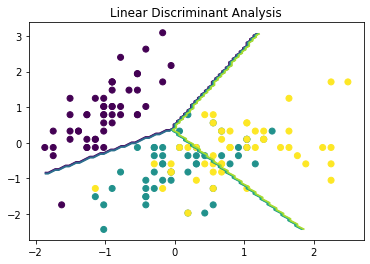

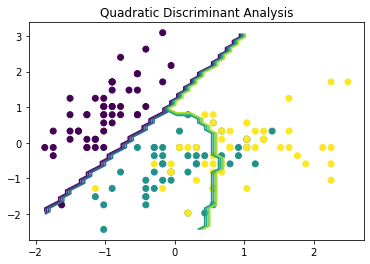

In [80]:
# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),np.arange(y_min, y_max, 0.05))
Z = predict_lda(np.c_[xx.ravel(), yy.ravel()],X,y)
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Linear Discriminant Analysis")
plt.show()

# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = predict_qda(np.c_[xx.ravel(), yy.ravel()],X,y)
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Quadratic Discriminant Analysis")
plt.show()

**Note** : Il est possible que le résultat visuel pour votre implémentation de LDA diffère de celle de Scikit-Learn vu précédemment. Cette différence est due à l'utilisation d'un algorithme d'optimisation pour l'apprentissage des paramètres du modèle.

## $k$-Plus Proches Voisins

### 1. Scikit-learn

In [81]:
#-- k-PPV
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y) 
y_pred = knn.predict(X)
print ("Taux d'erreur du 3-PPV", np.mean(y_pred != y))

Taux d'erreur du 3-PPV 0.14666666666666667


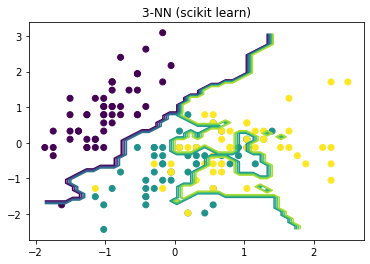

In [82]:
# Figure
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = knn.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("3-NN (scikit learn)")
plt.show()

### 2. Votre version de l'algorithme des $k$-Plus Proches Voisins

Astuces :
* `euclidean_distances()` calculer les distances entre échantillons ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html))
* `np.argsort()` donner les indices des points
* `np.unique()` pour avoir les éléments uniques d'une liste (et leur compte `return_counts=True`)
* `map(lambda i:y[i], tri.ravel())` donner les valeurs de y associées au i-ième indice, stocké dans la liste appelée tri

In [83]:
#-- Votre algorithme
def kPPV(X, Xtrain, ytrain, k=5):
    m = X.shape[0]
    ret = np.zeros(m,dtype=int)
    for i in range(m):
        sort = np.argsort(euclidean_distances(Xtrain,[X[i]]).flatten())
        classe = []
        w = k
        for j in sort[:k]:
            classe += [ytrain[j]] * w #pondération
            w -= 1
        uni, count = np.unique(classe,return_counts=True)
        ret[i] = uni[np.argmax(count)]
    return ret

In [84]:
kPPV(np.array([[0.5, 1.3],[-3.5,0.4],[1.5,-0.4]]),X,y, k=5)

array([2, 0, 2])

## Résultat attendu
array(\[2, 0, 2\])

In [85]:
#-- test
for k in [1,3,5,10,15,30]:
    yhat = kPPV(X,X,y,k=k)
    print ("Taux d'erreur "+str(k)+"-PPV", 1-getOA(y,yhat))
    print ("\tet coefficient Kappa", getKappa(y,yhat))

Taux d'erreur 1-PPV 0.07333333333333336
	et coefficient Kappa 0.8899999999999998
Taux d'erreur 3-PPV 0.10666666666666669
	et coefficient Kappa 0.84
Taux d'erreur 5-PPV 0.14
	et coefficient Kappa 0.7899999999999998
Taux d'erreur 10-PPV 0.1466666666666666
	et coefficient Kappa 0.7799999999999999
Taux d'erreur 15-PPV 0.15333333333333332
	et coefficient Kappa 0.77
Taux d'erreur 30-PPV 0.17333333333333334
	et coefficient Kappa 0.74


## Résultat attendu
Taux d'erreur 1-PPV 0.06000000000000005
    et coefficient Kappa 0.9099999999999999<br>
Taux d'erreur 3-PPV 0.15333333333333332
    et coefficient Kappa 0.77<br>
Taux d'erreur 5-PPV 0.16000000000000003
    et coefficient Kappa 0.7599999999999999<br>
Taux d'erreur 10-PPV 0.15333333333333332
    et coefficient Kappa 0.77<br>
Taux d'erreur 15-PPV 0.18666666666666665
    et coefficient Kappa 0.72<br>
Taux d'erreur 30-PPV 0.18000000000000005
    et coefficient Kappa 0.7299999999999999

**Note \#1** : Le taux d'erreur du 1-PPV devrait être de 0 % sur les échantillons d'apprentissage (chaque donnée d'apprentissage est la plus proche d'elle-même). **Comment pouvez vous expliquer le taux d'erreur de 6 % observé ?**

**Note \#2** : Il est rare d'utiliser une implémentation naïve du $k$-PPV qui calcule une distance entre chaque paire d'échantillons (coûteuse en mémoire et en temps). Pour aller plus loin : K-d tree.

**Note \#3** : En plus de l'hyperparamètre $k$ à fixer, le choix de la distance est aussi un hyperparamètre. Dans cet exemple, nous utilisons la distance euclidienne, mais vous pouvez tester d'autres types de distance (par exemple Minkowski pour $p\neq 2$)

### 3. Visualisation des frontières de décision

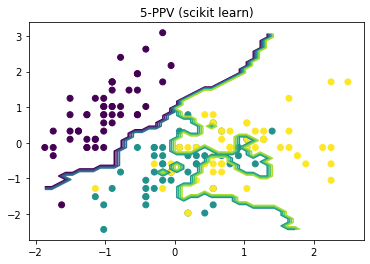

In [86]:
# Figure
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = kPPV(np.c_[xx.ravel(), yy.ravel()],X,y,k=5)
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("5-PPV (scikit learn)")
plt.show()